<a href="https://colab.research.google.com/github/jnsbrdbr/thesis/blob/thesis/part7_TGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.8.0


In [2]:
import keras
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 5.1 MB/s 


In [5]:
with open('/content/drive/MyDrive/10000/Tresult.pkl', "rb") as fh:
  result = pickle.load(fh)

In [6]:
#final data
print(result)

              0         1          2  ...         8         9  label
0     -2.231665 -3.223353  -0.847867  ... -0.068575 -0.230930      1
1     -2.231665 -3.223353  -0.847867  ... -0.068575 -0.230930      1
2     -2.231665 -3.223353  -0.847867  ... -0.068575 -0.230930      1
3     -2.231665 -3.223353  -0.847867  ... -0.068575 -0.230930      1
4     -2.231871 -3.223762  -0.848254  ...  0.048557  0.160622      1
...         ...       ...        ...  ...       ...       ...    ...
13209 -2.231665 -3.223353  -0.847867  ...  0.046943  0.150109      0
13210 -2.857167 -4.505172  18.597988  ... -0.129873 -0.451315      0
13211 -2.231665 -3.223353  -0.847867  ...  0.063843  0.211098      0
13212 -2.231665 -3.223353  -0.847867  ...  0.063843  0.211097      0
13213 -2.231665 -3.223353  -0.847867  ...  0.013998  0.046459      0

[13214 rows x 101 columns]


In [7]:
#divide data in to data_label and non_data label

import copy
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel
y=result.label

In [8]:
#splitting data in to test and train...

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=42,test_size=0.3)#

In [9]:
print('shape of x_train is:',X_train.shape)
print('shape of x_test is:',X_test.shape)

shape of x_train is: (9249, 100)
shape of x_test is: (3965, 100)


In [10]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [11]:
make_latent_samples(1, 300) # generates one sample

array([[ 1.18420416, -1.06675194,  0.58816291,  0.24609459, -0.23525952,
        -0.82964129, -0.82004766,  0.98777229,  2.28255446,  1.0725971 ,
         0.14359282, -0.97170062,  0.38765227,  0.78251772,  0.07561286,
        -0.26805256,  0.22145372,  0.37413115,  0.37414367, -0.80198546,
         0.39561272,  0.2247013 ,  0.93504786,  0.75571213,  0.33508225,
        -0.98234316, -0.78683321,  0.1353941 ,  1.10646159,  0.17242266,
        -0.49579786, -0.81816207, -0.24429544, -2.234923  , -1.1640056 ,
        -0.06660305,  0.0371494 ,  0.27801591,  0.7954723 ,  0.70060434,
         0.35175455,  1.74493306, -0.70639615, -0.09300478,  0.47183606,
         1.18366569, -0.17297846, -0.26841002, -0.32174465, -0.42782852,
         0.90403092,  1.41500485, -2.08350663,  0.19634855,  0.16894469,
         1.66360129, -0.85961928, -0.01940469, -0.31934152, -1.43302744,
         0.57608053, -2.74427569,  0.51951003,  1.18912672,  0.32540847,
        -0.24703661,  0.07594103, -0.19268473, -0.5

In [12]:
generator = Sequential([
    Dense(256, input_shape=(300,)),
    LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(512),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(256),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(128),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    Dense(100),
    Activation('tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               77056     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               25700     
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
Total params: 102,756
Trainable params: 102,756
Non-trainable params: 0
_________________________________________________________________


In [13]:
discriminator = Sequential([
    Dense(128, input_shape=(100,)),
    LeakyReLU(alpha=0.02),
    #(momentum=0.6),
    Dense(64),
    LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    Dense(32),
    LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(16),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    #Dense(8),
    #LeakyReLU(alpha=0.02),
    #BatchNormalization(momentum=0.6),
    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               12928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)               

In [14]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 100)               102756    
                                                                 
 discriminator (Sequential)  (None, 1)                 23297     
                                                                 
Total params: 126,053
Trainable params: 126,053
Non-trainable params: 0
_________________________________________________________________


In [15]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [16]:
make_trainable(discriminator, False)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               12928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)               

In [17]:
make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               12928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)               

In [18]:
def make_simple_GAN(sample_size, 
                    g_hidden_size_1,
                    g_hidden_size_2,
                    g_hidden_size_3,
                    g_hidden_size_4,
                    d_hidden_size_1,
                    d_hidden_size_2, 
                    d_hidden_size_3,
                    d_hidden_size_4,
                    d_hidden_size_5,
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size_1, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(g_hidden_size_2),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(g_hidden_size_3),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(g_hidden_size_4),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        Dense(100),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size_1, input_shape=(100,)),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        Dense(d_hidden_size_2),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        Dense(d_hidden_size_3),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(d_hidden_size_4),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        #Dense(d_hidden_size_5),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.6),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

In [19]:
from sklearn import preprocessing
def preprocess(x):
   x = preprocessing.scale(x)
   return x

In [20]:
X_train_real = np.array(preprocess(X_train))
X_test_real  = np.array(preprocess(X_test))

In [21]:
while(False):

  def deprocess(x):
    x = (x / 2 + 1) * 7454.516836076623
    x = np.clip(x, -127.3838709715454, 7454.516836076623)
    x = np.uint8(x)
    x = x.reshape(-1, 70)
    return x

In [22]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [23]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [24]:
# hyperparameters
sample_size     = 300     # latent sample size (i.e., 100 random numbers)
g_hidden_size_1 = 256
g_hidden_size_2 = 0
g_hidden_size_3 = 0
g_hidden_size_4 = 0
d_hidden_size_1 = 128
d_hidden_size_2 = 64
d_hidden_size_3 = 32
d_hidden_size_4 = 16
d_hidden_size_5 = 8
leaky_alpha     = 0.02
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 150
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1


In [25]:
## labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size_1, 
    g_hidden_size_2,
    g_hidden_size_3,
    g_hidden_size_4, 
    d_hidden_size_1, 
    d_hidden_size_2,
    d_hidden_size_3,
    d_hidden_size_4,
    d_hidden_size_5,
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)


losses = []
losses1 = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
   # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))

    #d_acc_real = discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
    #d_acc_fake = discriminator.train_on_batch(X_batch_fake, y_train_fake)
    #d_acc  = 0.5 * (d_acc_real + d_acc_fake)

    #losses1.append(( d_acc))
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f} ".format(
        e+1, epochs, d_loss, g_loss)) #Discriminator acc: {:>6.4f}:,d_acc

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch:   1/150 Discriminator Loss: 0.4578 Generator Loss: 2.2190 
Epoch:   2/150 Discriminator Loss: 0.4620 Generator Loss: 3.7440 
Epoch:   3/150 Discriminator Loss: 0.1548 Generator Loss: 4.1563 
Epoch:   4/150 Discriminator Loss: 0.1929 Generator Loss: 4.7985 
Epoch:   5/150 Discriminator Loss: 0.1411 Generator Loss: 4.8723 
Epoch:   6/150 Discriminator Loss: 0.2332 Generator Loss: 5.3517 
Epoch:   7/150 Discriminator Loss: 0.1946 Generator Loss: 5.5594 
Epoch:   8/150 Discriminator Loss: 0.1143 Generator Loss: 6.1581 
Epoch:   9/150 Discriminator Loss: 0.1443 Generator Loss: 5.2806 
Epoch:  10/150 Discriminator Loss: 1.0909 Generator Loss: 6.2030 
Epoch:  11/150 Discriminator Loss: 0.2067 Generator Loss: 7.1862 
Epoch:  12/150 Discriminator Loss: 0.1278 Generator Loss: 7.2577 
Epoch:  13/150 Discriminator Loss: 0.1285 Generator Loss: 6.9460 
Epoch:  14/150 Discriminator Loss: 0.8077 Generator Loss: 7.4593 
Epoch:  15/150 Discriminator Loss: 0.2668 Generator Loss: 8.1676 
Epoch:  16

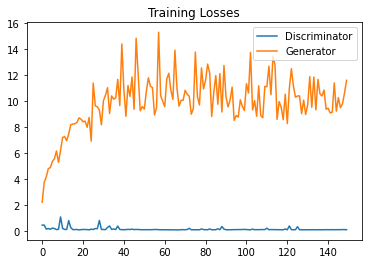

In [26]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [27]:
rr = discriminator.predict_on_batch(X_test_real)

In [28]:
y_test

8413     1
4816     1
13008    0
1355     1
4464     1
        ..
10000    0
3958     1
7768     1
3034     1
11792    0
Name: label, Length: 3965, dtype: int64

In [29]:
rr

array([[0.8903872 ],
       [0.9059459 ],
       [0.8807073 ],
       ...,
       [0.89523345],
       [0.9022951 ],
       [0.90893507]], dtype=float32)

In [30]:
import keras
#import keras_metrics

r = tf.keras.metrics.Recall()#thresholds=rr.min())
r.update_state(y_test,rr )
r.result().numpy()


0.9990003

In [31]:
p=tf.keras.metrics.Precision()#thresholds=rr.min())
p.update_state(y_test,rr )
p.result().numpy()

0.7605277